In [1]:
!pip install download
!pip install statsmodels 
!pip3 install -U scikit-learn scipy matplotlib
!pip install geopandas

#!/usr/bin/env python
# -*- coding: utf-8 -*-

import os
import sys
sys.path.append("./Methods")
import urllib.request

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import geopandas as gpd
import matplotlib.gridspec as gridspec

In [2]:

import zipfile


class Agros_class:
    """A class for analyzing agricultural data"""
    def __init__(self):
        '''
        Initialize the Agros_class object
        Parameters
        nothing
        ------------
        Returns
        nothing
        ---------
        '''
        self.data = None
        self.file = False
        self.download_file()
        self.read_data()
        

    def download_file(self):
        '''
        Download data file into downloads/ directory
        Parameters
        nothing
        ------------
        Returns
        nothing
        ---------
        '''
        url = "https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/Agricultural%20total%20factor%20productivity%20(USDA)/Agricultural%20total%20factor%20productivity%20(USDA).csv"
        file_path = "downloads/data_file.csv"
        
        geo_url = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/cultural/ne_50m_admin_0_countries.zip"
        geo_path = "downloads/ne_50m_admin_0_countries.zip"
        
        if not os.path.exists("downloads"):
            os.makedirs("downloads")
        
        if os.path.exists(file_path):
            print("Agri File already exists, skipping download")
        else:
            print("Downloading Agri file from URL...")
            urllib.request.urlretrieve(url, file_path)
            print("Agri File downloaded successfully")
            
            
        try:
            if not os.path.exists(geo_path):
                req = urllib.request.Request(
                    geo_url,
                    data=None,
                    headers={
                        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
                    }
                )
                with urllib.request.urlopen(req) as response, open(geo_path, 'wb') as out_file:
                    out_file.write(response.read())
                print("Geo File downloaded successfully")
            else:
                print("Geo File already exists, skipping download")
        except Exception as e:
            print(f"Error downloading Geo file: {e}")
        
        self.file = True


    def read_data(self):
        '''
        Read data file into a Pandas DataFrame
        Parameters
        nothing
        ------------
        Returns
        nothing
        ---------
        '''
        file_path = "downloads/data_file.csv"
        if os.path.exists(file_path):
            self.data = pd.read_csv(file_path)
            print("Agri Data loaded successfully into a Pandas DataFrame")
        else:
            print("Agri Data file not found")
            
        geo_path = "downloads/ne_50m_admin_0_countries.zip"    
        if os.path.exists(geo_path):
            shpfile = "zip://downloads/ne_50m_admin_0_countries.zip"
            self.geo = gpd.read_file(shpfile)
            print("Geo Data loaded successfully into a GeoPandas DataFrame")
        else:
            print("Geo Data file not found")
        
            
        

    def get_countries(self):
        '''
        Get a list of the available countries in the data set
        Parameters
        nothing
        ------------
        Returns
        A list of the available countries in the data set
        ---------
        '''
        if self.data is not None:
            return list(self.data['Entity'].unique())
        else:
            print("Data not loaded yet")
    
    def plot_quantity_correlation(self):
        '''
        Plot a correlation matrix between the "_quantity" columns in the dataset
        Parameters
        ----------
        nothing
        ------------
        Returns
        ----------
        nothing
        '''
        if self.data is not None:
            # Select only columns that contain "_quantity"
            quantity_cols = [col for col in self.data.columns if '_quantity' in col]
            # Compute correlation matrix
            corr = self.data[quantity_cols].corr()
            # Plot heatmap of correlation matrix
            sns.heatmap(corr, annot=True, cmap='coolwarm')
            plt.show()
        else:
            print("Data not loaded yet")
    
    def plot_output_area_chart(self, country=None, normalize=False):
        '''
        Plot an area chart of the distinct "_output_" columns.
        '''
        if self.data is None:
            print("Data not loaded yet")
            return

        if country is None or country == 'World':
            data_to_plot = self.data.groupby('Year').sum().loc[:, 'ag_land_quantity':'irrigation_quantity']
        else:
            if country not in self.get_countries():
                raise ValueError(f"{country} does not exist in the dataset")

            data_to_plot = self.data[self.data['Entity'] == country].set_index('Year').loc[:, 'ag_land_quantity':'irrigation_quantity']

        if normalize:
            data_to_plot = data_to_plot.divide(data_to_plot.sum(axis=1), axis=0) * 100
            
        data_to_plot.plot.area()
        plt.xlabel("Year")
        plt.ylabel("Output")
        plt.title(f"{'World' if country is None else country} Output{' (Normalized)' if normalize else ''}")
        plt.show()
    
    def compare_output_total(self, countries):
        '''
        Compare the total output of selected countries across years and plot it
        Parameters
        ----------
        countries : str or list
            The name of a country or a list of country names to compare
        ------------
        Returns
        ----------
        nothing
        '''
        if self.data is None:
            print("Data not loaded yet")
            return
        
        # Convert string to list if only one country is provided
        if isinstance(countries, str):
            countries = [countries]
        
        # Filter data for selected countries
        filtered_data = self.data[self.data['Entity'].isin(countries)]
        
        # Compute total output for each year
        data_to_plot = filtered_data.groupby('Year').sum().loc[:, 'output':'output_quantity']
        data_to_plot['Total'] = data_to_plot.sum(axis=1)
        
        # Plot total output over time for each country
        for country in countries:
            plt.plot(data_to_plot.index, filtered_data[filtered_data['Entity']==country]['output'], label=country)
        
        plt.plot(data_to_plot.index, data_to_plot['Total'], label='Total')
        plt.legend()
        plt.xlabel('Year')
        plt.ylabel('Output (US$)')
        plt.show()
    
    def gapminder(self, year):
        '''
        Plot a scatter plot comparing fertilizer_quantity and output_quantity for a given year
        The area of each dot represents a third relevant variable
        Parameters
        ----------
        year: int
        The year to plot the scatter plot for
        ------------
        Returns
        ----------
        nothing
        '''
        # Check if year is an integer
        if not isinstance(year, int):
            raise TypeError("Year must be an integer")
            
        # Filter data for given year
        data_filtered = self.data[self.data['Year'] == year]
            
        # Set area size based on a third relevant variable (here, 'land_area' column)
        area_size = data_filtered['ag_land_quantity']/1000
        
        # Plot scatter plot
        plt.scatter(data_filtered['fertilizer_quantity'], data_filtered['output_quantity'], s=area_size,  alpha=0.4, edgecolors='grey', linewidth=2)
        plt.figure(figsize=(10, 5))
        # Set plot title and axis labels
        plt.title(f"Gapminder Plot for year {year}")
        plt.xlabel("Fertilizer Quantity")
        plt.ylabel("Output Quantity")
        plt.xscale("log")
        plt.yscale("log")
            
        # Show plot
        plt.show()
        
    def choropleth(self, year):
        """
        Creates a choropleth map of the world for a given year.
    
        Parameters
        ----------
        year : int
            The year for which the map should be created.

        Returns
        -------
        A choropleth map of the world for a given year.
        """
    
        if not isinstance(year, int):
            raise ValueError("Year must be an integer.")
        
        
         # Dictionary for merging countries
        self.merge_dict = {
            'United States': 'United States of America',
            'Dominican Republic' : 'Dominica',
            'Democratic Republic of Congo':'Democratic Republic of the Congo',
            'Congo' :'Republic of the Congo',
            'Democratic Republic of Congo':'Dem. Rep. Congo',
            'Bahamas' : 'The Bahamas',
            'United Republic of Tanzania' : 'Tanzania',
            'Eswatini' : 'eSwatini',
            'Myanmar' : 'Burma',
            'North Macedonia' : 'Macedonia, Republic of',
            'Central African Republic' : 'Central African Rep.',
            'South Sudan' : 'S. Sudan'
        }

        
        
        # Filter data for given year
        self.data = self.data[self.data['Year'] == year]
        
        #Get the average of the tfp of country in that given year
        tpf_avg_df = self.data.groupby("Entity")["tfp"].mean().reset_index()
        
        # Rename country names to match the ones in the geographical data
        tpf_avg_df['Entity'] = tpf_avg_df['Entity'].replace(self.merge_dict) 
        
        # Read geographical data
        geo_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
         
        # Merge dataframes
        merge_data = geo_data.merge(tpf_avg_df, left_on='name', right_on='Entity')
        
      # Plot choropleth map
       # Define color scheme
        cmap = 'RdBu'

        # Create figure and gridspec
        fig = plt.figure(figsize=(20, 10))
        gs = fig.add_gridspec(2, 1, height_ratios=[8, 1])

        # Plot the data on the top panel
        ax = fig.add_subplot(gs[0])
        ax.set_title(f"Agricultural Total Factor Productivity in {year}", fontsize=25)
        merge_data.plot(column='tfp', cmap=cmap, ax=ax, legend=True, legend_kwds={'label': "TFP"}, vmin=merge_data['tfp'].min(), vmax=merge_data['tfp'].max(), edgecolor='grey', linewidth=0.5)

        # Add colorbar
        cax = fig.add_subplot(gs[1])
        cbar = plt.colorbar(ax.collections[0], cax=cax, orientation='horizontal')
        cbar.ax.tick_params(labelsize=15)
        cbar.set_label('TFP', fontsize=20)

        # Add a nice background
        sns.set_style("darkgrid")
        ax.set_facecolor('white')

        # Add source text on the bottom
        source_text = "Source: Our World in Data (2019); Agricultural Total Factor Productivity (xx)"
        fig.text(0.85, 0.03, source_text, fontsize=15, color='grey')

        plt.show()
        



In [3]:
    def predictor(self,countries):
        if self.data is None:
            print("Data not loaded yet")
            return
        if isinstance(countries, str):
            countries = [countries]
        filtered_data = self.data[self.data['Entity'].isin(countries)]
        colors = ['blue', 'green', 'red']
        for i, country in enumerate(countries):
            dfs=filtered_data[filtered_data['Entity']==country]
            data=dfs[['Year','tfp']]
            x=data['Year']
            y=data['tfp']
            model=ARIMA(y,order=(5,1,1))
            model_fit=model.fit()
            additional_points=31
            yhat = model_fit.predict(len(y), len(y)+additional_points-1, typ='levels')
            xhat=np.arange(0, additional_points)+2018+1
            plt.plot(x, y,c=colors[i],label=country)
            plt.plot(xhat, yhat,c=colors[i],linestyle='--')
            plt.xlabel('Year')
            plt.ylabel('TFP')
            plt.legend()


In [4]:
    # Import auto_arima
    from pmdarima import auto_arima 

    # Ignore the warnings, as some parameters may be incompatible with some ARIMA settings 
    import warnings 
    warnings.filterwarnings("ignore") 

    # Fit the several
    stepwise_fit = auto_arima(dair['Passengers'],
                              start_p = 1,
                              start_q = 1, 
                              max_p = 3,
                              max_q = 3,
                              m = 12, 
                              start_P = 0,
                              seasonal = True, 
                              d = None,
                              D = 1,
                              trace = True, 
                              error_action ='ignore',   # Ignore incompatible settings
                              suppress_warnings = True,  
                              stepwise = True)           

# To print the summary 
stepwise_fit.summary() 

NameError: name 'dair' is not defined

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# load data
#Agriculture_df = pd.read_csv('Agriculture.csv', index_col='Year')

# define predictor method
def predictor(country_list):
    # filter dataframe for selected countries
    valid_countries = []
    for country in country_list:
        if country in self.data.columns:
            valid_countries.append(country)
        else:
            print(f"{country} is not available in the dataset and will be ignored.")
    if not valid_countries:
        raise ValueError("None of the selected countries are available in the dataset.")
    df = self.data[valid_countries]
    
    # plot actual tfp data
    plt.figure(figsize=(10, 5))
    for country in valid_countries:
        plt.plot(df[country], label=country)
    plt.title('Total Factor Productivity')
    plt.xlabel('Year')
    plt.ylabel('TFP')
    plt.legend()
    plt.show()
    
    # create ARIMA model and predict up to 2050
    arima_order = (1, 1, 1)
    predictions = pd.DataFrame()
    for country in valid_countries:
        arima = ARIMA(df[country], order=arima_order)
        arima_fit = arima.fit()
        future_dates = pd.date_range(start='2016', end='2050', freq='Y')
        future_df = pd.DataFrame(index=future_dates, columns=df.columns)
        future_df[country] = arima_fit.predict(start=len(df), end=len(df)+34, typ='levels')
        predictions = pd.concat([predictions, future_df], axis=1)
    
    # plot predicted tfp data
    linestyles = ['--', '-.', ':']
    linestyle_index = 0
    plt.figure(figsize=(10, 5))
    for country in valid_countries:
        plt.plot(df.index.union(predictions.index), df[country].append(predictions[country]), 
                 label=country, linestyle=linestyles[linestyle_index])
        linestyle_index = (linestyle_index + 1) % len(linestyles)
    plt.title('Total Factor Productivity Predictions')
    plt.xlabel('Year')
    plt.ylabel('TFP')
    plt.legend()
    plt.show()


In [6]:
  
  #ULTIMISSIMO  
    
    # define predictor method
    def predictor(self, country_list):
        # filter dataframe for selected countries
        valid_countries = []
        for country in country_list:
            if country in self.data.columns:
                valid_countries.append(country)
            else:
                print(f"{country} is not available in the dataset and will be ignored.")
        if not valid_countries:
            raise ValueError("None of the selected countries are available in the dataset.")
        df = self.data[valid_countries]

        # plot actual tfp data
        plt.figure(figsize=(10, 5))
        for country in valid_countries:
            plt.plot(df[country], label=country)
        plt.title('Total Factor Productivity')
        plt.xlabel('Year')
        plt.ylabel('TFP')
        plt.legend()
        plt.show()

        # create ARIMA model and predict up to 2050
        arima_order = (1, 1, 1)
        predictions = pd.DataFrame()
        for country in valid_countries:
            arima = ARIMA(df[country], order=arima_order)
            arima_fit = arima.fit()
            future_dates = pd.date_range(start='2016', end='2050', freq='Y')
            future_df = pd.DataFrame(index=future_dates, columns=df.columns)
            future_df[country] = arima_fit.predict(start=len(df), end=len(df)+34, typ='levels')
            predictions = pd.concat([predictions, future_df], axis=1)

        # plot predicted tfp data
        linestyles = ['--', '-.', ':']
        linestyle_index = 0
        plt.figure(figsize=(10, 5))
        for country in valid_countries:
            plt.plot(df.index.union(predictions.index), df[country].append(predictions[country]), 
                     label=country, linestyle=linestyles[linestyle_index])
            linestyle_index = (linestyle_index + 1) % len(linestyles)
        plt.title('Total Factor Productivity Predictions')
        plt.xlabel('Year')
        plt.ylabel('TFP')
        plt.legend()
        plt.show()


IndentationError: unexpected indent (3200043435.py, line 4)

In [11]:
    
    # define predictor method
    def predictor(country_list):
    # filter dataframe for selected countries
        valid_countries = []
        for country in country_list:
            if country in self.data.columns:
                valid_countries.append(country)
            else:
                print(f"{country} is not available in the dataset and will be ignored.")
        if not valid_countries:
            raise ValueError("None of the selected countries are available in the dataset.")
        df = self.data[valid_countries]

        # plot actual tfp data
        plt.figure(figsize=(10, 5))
        for country in valid_countries:
            plt.plot(df[country], label=country)
        plt.title('Total Factor Productivity')
        plt.xlabel('Year')
        plt.ylabel('TFP')
        plt.legend()
        plt.show()

        # create ARIMA model and predict up to 2050
        arima_order = (1, 1, 1)
        predictions = pd.DataFrame()
        for country in valid_countries:
            arima = ARIMA(df[country], order=arima_order)
            arima_fit = arima.fit()
            future_dates = pd.date_range(start='2016', end='2050', freq='Y')
            future_df = pd.DataFrame(index=future_dates, columns=df.columns)
            future_df[country] = arima_fit.predict(start=len(df), end=len(df)+34, typ='levels')
            predictions = pd.concat([predictions, future_df], axis=1)

        # plot predicted tfp data
        linestyles = ['--', '-.', ':']
        linestyle_index = 0
        plt.figure(figsize=(10, 5))
        for country in valid_countries:
            plt.plot(df.index.union(predictions.index), df[country].append(predictions[country]), 
                     label=country, linestyle=linestyles[linestyle_index])
            linestyle_index = (linestyle_index + 1) % len(linestyles)
        plt.title('Total Factor Productivity Predictions')
        plt.xlabel('Year')
        plt.ylabel('TFP')
        plt.legend()
        plt.show()




In [12]:
x = Agros_class()

Agri File already exists, skipping download
Geo File already exists, skipping download
Agri Data loaded successfully into a Pandas DataFrame
Geo Data loaded successfully into a GeoPandas DataFrame


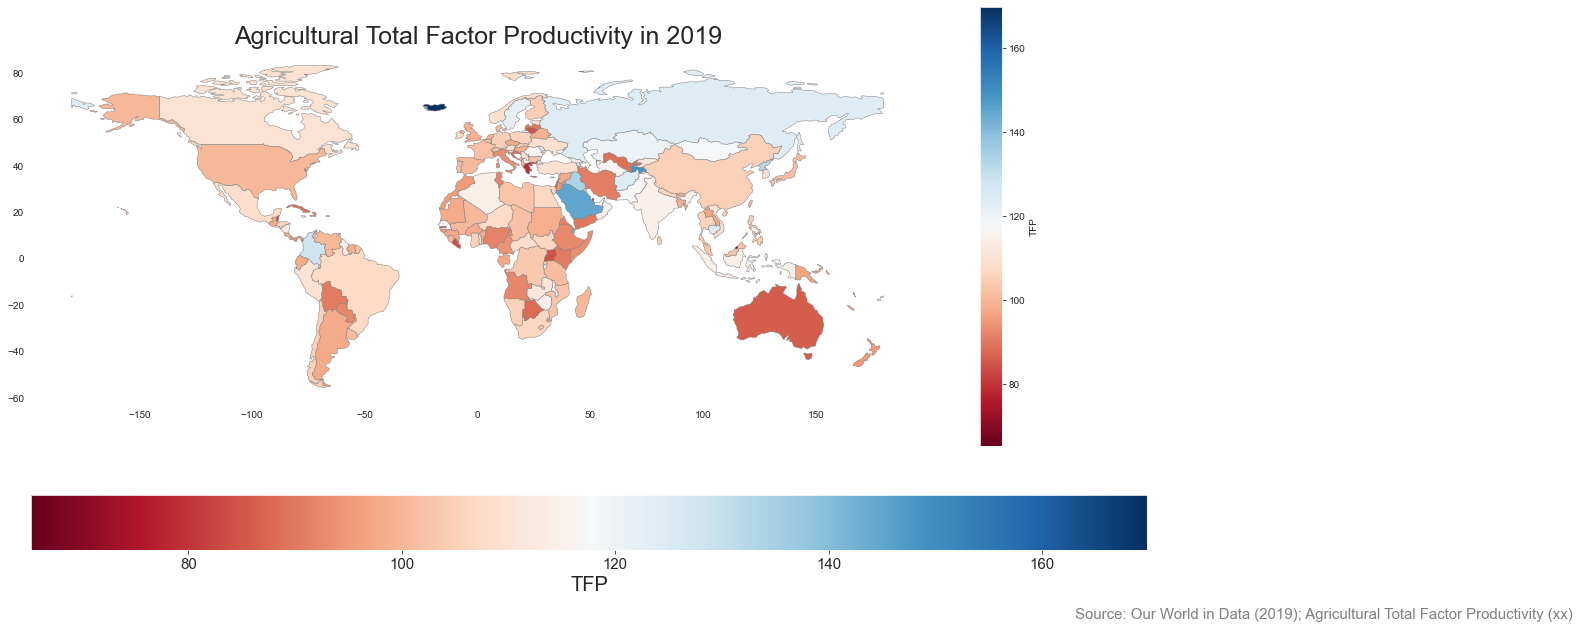

In [17]:
x.choropleth(2019)

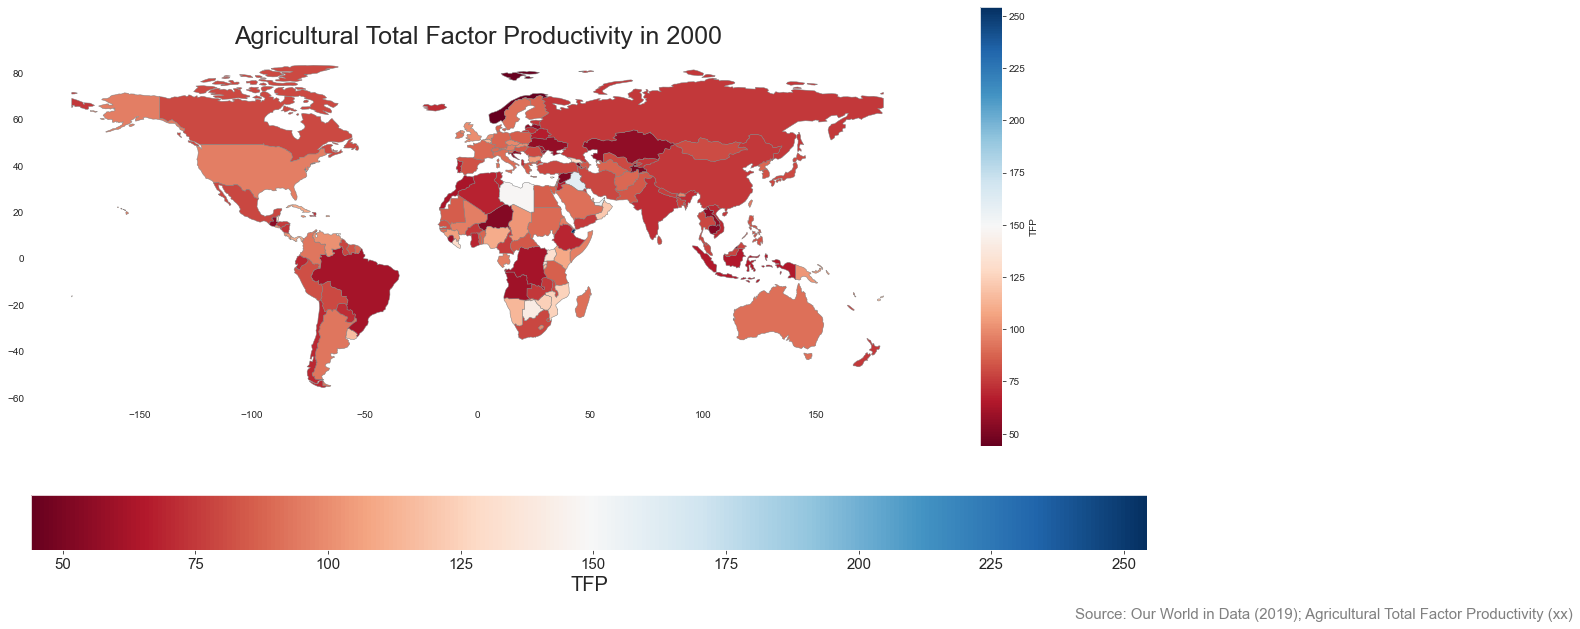

In [19]:
x.choropleth(2000)

In [13]:
x.predictor('Spain', 'Canada', 'Japan')

AttributeError: 'Agros_class' object has no attribute 'predictor'